## Ch03. 평가
성능 평가 지표
1. 회귀: 대부분 실제값과 예측값의 오차 평균값에 기반  
2. **분류**:
    - 정확도(Accuracy)
    - 오차행렬(Confusion Matrix)
    - 정밀도(Precision)
    - 재현율(Recall)
    - F1 스코어
    - ROC AUC

해당 분류의 성능 지표는 이진/멀티 분류 모두에 적용되는 지표이지만, 특히 이진 분류에서 더욱 중요하게 강조하는 지표

### 1. 정확도(Accuracy)


실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표
- 정확도(Accuracy) = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수
- 이진 분류의 경우 데이터의 구성에 따라 ML 모델의 성능을 왜곡할 수 있기에 정확도 수치만 가지고 성능 평가 X
    - 탑승객이 여자인 경우에 생존 확률이 높았기에 별다른 알고리즘의 적용 없이 무조건 성별이 여자인 경우 생존으로 예측해도 정확도가 80%
- 불균형한(imbalanced) 레이블 값 분포에서 ML 모델의 성능을 판단할 경우에 적합한 평가 지표가 아님
    - 100개의 데이터 중 90개의 레이블이 0, 10개가 1일 때 무조건 0으로 예측하는 ML 모델의 정확도는 90%

In [2]:
# 정확도 지표가 ML 모델의 성능을 왜곡하는 경우 예제

import numpy as np
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # fit( ) 메소드는 아무것도 학습하지 않음
    def fit(self, X , y=None):
        pass

    # predict( ) 메소드는 단순히 Sex 피처가 1 이면 0, 그렇지 않으면 1로 예측함
    def predict(self, X):
        pred = np.zeros( ( X.shape[0], 1 ))
        for i in range (X.shape[0]) :
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else :
                pred[i] = 1
        
        return pred

사이킷런의 BaseEstimator 클래스를 상속받아 학습을 하지 않고, 성별에 따라 생존자를 예측하는 단순한 Classifier를 생성

In [3]:
# 데이터 가공을 수행할 함수

from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 피처 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test=train_test_split(X_titanic_df, y_titanic_df,
                                                  test_size=0.2, random_state=0)

# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는: 0.7877


→ 단순한 알고리즘으로 예측을 하더라도 데이터의 구성에 따라 정확도 결과로 높은 수치가 나올 수 있음

In [5]:
# 데이터 레이블 분포도가 균일하지 않은 경우 무조건 특정한 결과로 예측하게 해도 정확도가 높은 수치로 나타나는 예제

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self,X,y):
        pass
    
    # 입력값으로 들어오는 X 데이터 셋의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self,X):
        return np.zeros( (len(X), 1) , dtype=bool)

# 사이킷런의 내장 데이터 셋인 load_digits( )를 이용하여 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split( digits.data, y, random_state=11)

불균형한 데이터 세트와 Dummy Classifier를 생성

In [6]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train , y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
Name: count, dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


→ 단순히 predict()의 결과를 모두 0값으로 반환함에도 불구하고 450개의 테스트 데이터 세트에 수행한 예측 정확도는 90%
- 정확도는 여러 가지 분류 지표와 함께 적용하여 ML 모델 성능을 평가해야 함

### 2. 오차 행렬(Confusion Matrix)
예측 오류가 얼마인지와 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 나타내는 지표
* 앞 문자 True/False는 예측값과 실제값이 '같은가/틀린가'를 의미
* 뒷 문자 Negative/Positive는 예측 결과 값이 부정(0)/긍정(1)을 의미
  * TN: 예측값을 Negative 값 0으로 예측했고 실제 값 역시 Negative 값 0
  * FP: 예측값을 Positive 값 1로 예측했는데 실제 값은 Negative 값 0
  * FN: 예측값을 Negative 값 0으로 예측했는데 실제 값은 Positive 값 1
  * TP: 예측값을 Positive 값 1로 예측했고 실제 값 역시 Positive 값 1

In [7]:
from sklearn.metrics import confusion_matrix

# 앞절의 예측 결과인 fakepred와 실제 결과인 y_test의 Confusion Matrix출력
confusion_matrix(y_test , fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

정확도 예제의 MyFakeClassifier의 예측 성능 지표를 오차 행렬로 표현

* TP, TN, FP, TN 값을 조합해 Classifier의 성능 지표인 정확도, 정밀도, 재현도 값을 계산할 수 있음
* 정확도 = 예측 결과와 실제 값이 동일한 건수 / 전체 데이터 수 = (TN + TP) / (TN + FP + FN + TP)

### 3. 정밀도(Precision)과 재현율(Recall)
* 정밀도: 예측을 Positive로 한 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율
  * **정밀도 = TP / (FP + TP)**
  * 양성 예측도
* 재현율: 실제 값이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율
  * **재현율 = TP / (FN + TP)**
  * 민감도(Sensitivity), TPR(True Positive Rate)
* Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표

* 이진 분류 모델의 업무 특성에 따라 특정 평가 지표가 상대적으로 더 중요한 지표로 간주됨
  * 재현율이 더 중요한 지표: 실제 Positive 양성인 데이터 예측을 Negative로 잘못 판단하게 되면 업무 상 큰 영향이 발생하는 경우
  * 정밀도가 더 중요한 지표: 실제 Negative 음성인 데이터 예측을 Positive 양성으로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우
* 가장 좋은 성능 평가는 재현율과 정밀도 모두 높은 수치를 얻는 것

In [12]:
# 오차행렬, 정확도, 정밀도, 재현율을 한꺼번에 계산하는 함수 생성

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test , pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [13]:
# 로지스틱 회귀 기반으로 타이타닉 생존자를 예측하고 오차행렬, 정확도, 정밀도, 재현율 평가를 수

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습데이터/테스트 데이터 분할
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                    test_size=0.20, random_state=11)

lr_clf = LogisticRegression(solver='liblinear')

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test , pred)

오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705


LogisticRegression 객체의 생성 인자 solver='liblinear'는 로지스틱 회귀의 최적화 알고리즘으로, 보통 작은 데이터 세트의 이진 분류인 경우에 적합함. solver의 기본값은 lbfgs이며 데이터 세트가 상대적으로 크고 다중 분류인 경우 적합함.

### 정밀도/재현율 트레이드오프
* 업무에 따라 분류의 결정 임곗값(Threshold)을 조정해 정밀도 또는 재현율의 수치를 높일 수 있음
* 정밀도/재현율의 트레이드오프(Trade-off): 정밀도와 재현율은 상호 보완적인 평가 지표

**predict_proba( ) 메소드 확인**  
사이킷런의 분류 알고리즘은 개별 레이블 별로 결정 확률을 구하고 그 예측 확률이 큰 레이블 값으로 예측

In [14]:
# 타이타닉 생존자 데이터를 학습한 LogisticRegression 객체의 예측 확률과 예측 결과 값을 확인

pred_proba = lr_clf.predict_proba(X_test)
pred  = lr_clf.predict(X_test)
print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array와 예측 결과값 array를 concatenate 하여 예측 확률과 결과값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba , pred.reshape(-1,1)],axis=1)
print('두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n',pred_proba_result[:3])

pred_proba()결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.44935225 0.55064775]
 [0.86335511 0.13664489]
 [0.86429643 0.13570357]]
두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.44935225 0.55064775 1.        ]
 [0.86335511 0.13664489 0.        ]
 [0.86429643 0.13570357 0.        ]]


→ 두 개의 칼럼에서 더 큰 확률 값으로 predict() 메소드가 최종 예측
* predict()는 predict_proba() 호출 결과로 반환된 배열에서 분류 결정 임곗값보다 큰 값이 들어 있는 칼럼의 위치를 받아서 최종적으로 예측 클래스를 결정하는 API
* 사이킷런은 분류 결정 임곗값을 조절해 정밀도와 재현율의 성능 수치를 상호 보완적으로 조정 가능

**Binarizer 클래스의 사용법**  
입력된 데이터 세트에서 Binarizer의 threshold 값보다 같거나 작으면 0값으로, 크면 1값으로 변환해 반환

In [15]:
from sklearn.preprocessing import Binarizer

X = [[ 1, -1,  2],
     [ 2,  0,  0],
     [ 0,  1.1, 1.2]]

# threshold 기준값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)                     
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


**분류 결정 임계값 0.5 기반에서 Binarizer를 이용하여 예측값 변환**

In [16]:
# Binarizer를 이용한 predict()의 pseudo code
# pred_proba 객체 변수에 threshold를 0.5로 설정한 Binarizer 클래스를 적용해 최종 예측값을 구하고 평가 지표 출력

from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값 (분류 결정 임곗값)
custom_threshold = 0.5

# predict_proba( ) 반환값의 두번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) 
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705


→ predict()로 계산된 지표 값과 정확히 동일

**분류 결정 임계값 0.4 기반에서 Binarizer를 이용하여 예측값 변환**

In [17]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤  
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) 
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197


→ 임곗값을 낮추니 재현율 값이 올라가고 정밀도가 떨어짐
* 분류 결정 임곗값은 Positive 예측값을 결정하는 확률의 기준이 되므로 임곗값을 낮출수록 Positive로 예측을 더 너그럽게 하기에 True 값이 많아짐
* 양성 예측을 많이하면 실제 양성을 음성으로 예측하는 횟수가 줄어 상대적으로 재현율 값이 높아짐

**분류 결정 임곗값을 증가시키면서 Binarizer를 이용하여 예측값 변환**

In [18]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):
    # thresholds list객체내의 값을 차례로 iteration하면서 Evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197
임곗값: 0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869
임곗값: 0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705
임곗값: 0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도: 0.8654, 재현율: 0.7377
임곗값: 0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213


**precision_recall_curve( ) API를 이용하여 임곗값에 따른 정밀도-재현율 값 추출**  
일반적으로 0.11~0.95 정도의 임곗값을 담은 넘파이 ndarray와 해당하는 정밀도/재현율 값을 담은 넘파이 ndarray를 반환

In [19]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추출 
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 

# 실제값 데이터 셋과 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력 
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)
print('반환된 precisions 배열의 Shape:', precisions.shape)
print('반환된 recalls 배열의 Shape:', recalls.shape)

print("thresholds 5 sample:", thresholds[:5])
print("precisions 5 sample:", precisions[:5])
print("recalls 5 sample:", recalls[:5])

# 반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값 
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shape: (165,)
반환된 precisions 배열의 Shape: (166,)
반환된 recalls 배열의 Shape: (166,)
thresholds 5 sample: [0.01974988 0.06956415 0.0840281  0.08474207 0.08920162]
precisions 5 sample: [0.34078212 0.34269663 0.34463277 0.34659091 0.34857143]
recalls 5 sample: [1. 1. 1. 1. 1.]
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임곗값:  [0.02 0.11 0.13 0.14 0.16 0.24 0.32 0.45 0.62 0.73 0.87]
샘플 임계값별 정밀도:  [0.341 0.372 0.401 0.44  0.505 0.598 0.688 0.774 0.915 0.968 0.938]
샘플 임계값별 재현율:  [1.    1.    0.967 0.902 0.902 0.902 0.869 0.787 0.705 0.492 0.246]


**임곗값의 변경에 따른 정밀도-재현율 변화 곡선을 그림**

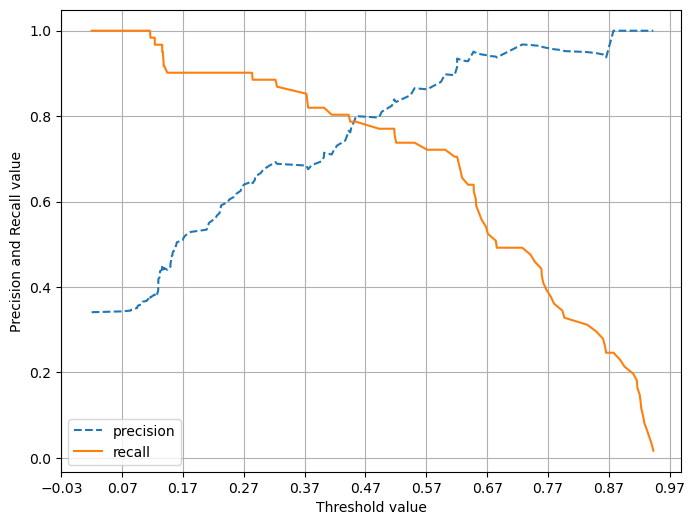

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

### 4. F1 스코어
: 정밀도와 재현율을 결합한 지표
* 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가짐
* #### $F1 = \frac{2}{\frac{1}{recall}+\frac{1}{precision}} = 2 * \frac{precision * recall}{precision + recall}$

In [21]:
# 로지스틱 회귀 기반 타이타닉 생존자 모델의 F1 스코어

from sklearn.metrics import f1_score 
f1 = f1_score(y_test , pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7966


In [22]:
# 타이타닉 생존자 예측에서 임곗값을 변화시키면서 F1 스코어를 포함한 평가 지표 확인

def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    # F1 스코어 추가
    f1 = f1_score(y_test,pred)
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4 , 0.45 , 0.50 , 0.55 , 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197, F1:0.7576
임곗값: 0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869, F1:0.7869
임곗값: 0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705, F1:0.7966
임곗값: 0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도: 0.8654, 재현율: 0.7377, F1:0.7965
임곗값: 0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213, F1:0.8000


### 5. ROC 곡선과 AUC
* ROC 곡선: FPR(False Positive Rate)이 변할 때 TPR(True Positive Rate)이 어떻게 변하는지 나타내는 곡선
  * TPR: 민감도, 재현율을 나타내므로 TPR = TP / (FN + TP)
  * TNR(True Negative Rate): 특이성, TPR에 대응하는 지표로 TNR = TN / (FP + TN)
  * **FPR = FP / (FP + TN) = 1 - TNR = 1 - 특이성**

![](./ROC_example.png)

* ROC 곡선의 가운데 직선은 ROC 곡선의 최저 값 (AUC = 0.5)
* ROC 곡선이 가운데 직선에 가까울수록 성능이 떨어지는 것이고 멀어질수록 성능이 뛰어남
* FPR을 0부터 1까지 변경하면서 TPR의 변화 값을 구함
  * FPR이 0 이려면 임곗값이 1 (Classifier의 Positive 예측 기준이 매우 높아 Positive로 예측하지 않음)
  * FPR이 1 이려면 임곗값이 0 (Classifier의 Positive 예측 기준이 매우 낮아 전부 Positive로 예측함)
  * 따라서 분류 결정 임곗값을 1에서 0으로 변경하면서 FPR을 0부터 1까지 변화를 확인

* AUC: ROC 곡선 밑의 면적을 구한 것
  * 일반적으로 이진 분류의 성능 평가를 위해 가장 많이 사용되는 지표 
  * 1에 가까울수록 좋은 수치 (FPR이 작은 상태에서 큰 TPR)

**roc_curve() API를 이용해 타이타닉 생존자 예측 모델의 FPR, TPR, 임곗값 확인**

In [23]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출 
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 Step으로 추출
# thresholds[0]은 max(예측 확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값: ', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46]
샘플 index로 추출한 임곗값:  [0.94 0.73 0.62 0.52 0.44 0.28 0.15 0.14 0.13 0.12]
샘플 임곗값별 FPR:  [0.    0.008 0.025 0.076 0.127 0.254 0.576 0.61  0.746 0.847]
샘플 임곗값별 TPR:  [0.016 0.492 0.705 0.738 0.803 0.885 0.902 0.951 0.967 1.   ]


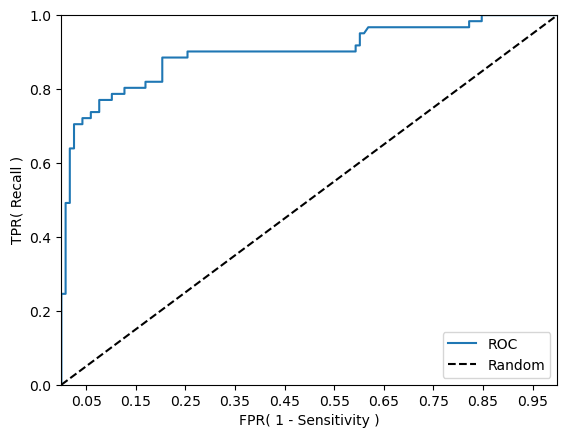

In [24]:
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X, Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1] )

**AUC 값 계산**

In [25]:
from sklearn.metrics import roc_auc_score
pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.8987


In [26]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
          F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))